In [1]:
#Basic notebook with a few jupyter examples - use case is calc out of date warranties
# Load and process a CSV

# Metrics to calc
 # number of product purchases that are either out of warranty or obsolete
# Users that haven't purchased in a while
# Last purchase per user - any product

#Last purchase per user - each product
#  * somehow include no purchases - for ones that they have been assigned


In [20]:
import pandas as pd
import logging
from datetime import date, timedelta
import seaborn as sns
from check_df import check_df, fix_empty_cells

logging.basicConfig(level=logging.DEBUG, format="%(message)s")
LOGGER = logging.getLogger('arappaport')
LOGGER.debug("log level = %s", str(LOGGER.getEffectiveLevel()))


log level = 10


In [27]:
# Params - Moved these to command line or env in final version 
DATA_PATH="./data/purchases.csv"
DATE_AS_OF=date.fromisoformat('2023-06-01') #Date for analysis
#For data visualization - date range sizes
DATE_GROUP_DAYS=30
CUTOFF_DAYS=90

REQUIRED_COLUMNS=['user','date','product', 'price']
REQUIRED_VALUES=['user', 'date','product']

#list of recommended actions for different date thresholds. 
ACTION_DATES = dict(out_of_warranty=30, obsolete=90)
#sort so the largest date value is first in dict.  i.e., we want to recommend the action with the largest date range
actions = {k: v for k, v in sorted(ACTION_DATES.items(), key=lambda item: item[1], reverse=True)} 
DEFAULT_ACTION='ok'


In [28]:
df_all = pd.read_csv(DATA_PATH)
df_all.head()

,user,date,product,price
0,A,2023-05-31,prod-a,17.0
1,B,2023-06-01,prod-a,NaN
2,C,2023-05-01,prod-b,256.0
3,D,2023-06-01,prod-a,118.0
4,D,2023-05-15,prod-a,224.0


In [29]:
# replace empty cells with None to clean up data.
fix_empty_cells(df_all, inplace=True)
df_all.head()

,user,date,product,price
0,A,2023-05-31,prod-a,17.0
1,B,2023-06-01,prod-a,NaN
2,C,2023-05-01,prod-b,256.0
3,D,2023-06-01,prod-a,118.0
4,D,2023-05-15,prod-a,224.0


In [30]:
#check dataframe for missing blocks.  err is empty if no errors - otherwise an err str
err = check_df(df_all, required_columns=REQUIRED_COLUMNS, required_values=REQUIRED_VALUES)
if err:
    print(str(err))
    Exception(err)
    
LOGGER.info("Loaded %d clean rows from CSV[%s]", len(df_all), DATA_PATH)


Num empty required cells in dataframe: 0
Loaded 22 clean rows from CSV[./data/purchases.csv]


In [31]:
df_all['date']

0     2023-05-31
1     2023-06-01
2     2023-05-01
3     2023-06-01
4     2023-05-15
5     2023-02-04
6     2023-02-07
7     2023-02-10
8     2023-02-13
9     2023-02-16
10    2023-02-19
11    2023-02-22
12    2023-02-25
13    2023-02-28
14    2023-03-03
15    2023-03-06
16    2023-03-09
17    2023-03-12
18    2023-03-15
19    2023-03-18
20    2023-03-21
21    2023-01-01
Name: date, dtype: object

In [32]:
#fixup convert 8601 strings to dates
df_all['date']      = pd.to_datetime(df_all['date'], format='%Y-%m-%d').dt.date

#Add number of days since date.   Makes some downstream calcs a little easier
df_all['days_ago'] = df_all['date'].apply(lambda x: (DATE_AS_OF - x).days)
df_all.head()


,user,date,product,price,days_ago
0,A,2023-05-31,prod-a,17.0,1
1,B,2023-06-01,prod-a,NaN,0
2,C,2023-05-01,prod-b,256.0,31
3,D,2023-06-01,prod-a,118.0,0
4,D,2023-05-15,prod-a,224.0,17


In [33]:
#Begin to count the recommend actions. 
def determine_action(days:int) ->str: 
    for action, d_thresehold in actions.items():
        if days >= d_thresehold:
            return action
    return DEFAULT_ACTION

df_all['action'] = df_all['days_ago'].apply(determine_action)
df_all.head(5)

#Find the ones beyond the dates. 

,user,date,product,price,days_ago,action
0,A,2023-05-31,prod-a,17.0,1,ok
1,B,2023-06-01,prod-a,NaN,0,ok
2,C,2023-05-01,prod-b,256.0,31,out_of_warranty
3,D,2023-06-01,prod-a,118.0,0,ok
4,D,2023-05-15,prod-a,224.0,17,ok


In [34]:
#####################################
#most recent purchases per user - any product
df_recent = df_all.sort_values(by='date', ascending=False)

# group the data by Name and get the first row of each group
df_most_recent_purchases = df_recent.groupby('user').first()
df_most_recent_purchases.head()


,date,product,price,days_ago,action
user,,,,,
A,2023-05-31,prod-a,17.0,1,ok
B,2023-06-01,prod-a,817.0,0,ok
C,2023-05-01,prod-b,256.0,31,out_of_warranty
D,2023-06-01,prod-a,118.0,0,ok
E,2023-01-01,prod-b,91.0,151,obsolete


In [35]:
#####################################
#most recent purchases per user - any product

df_recent = df_all.sort_values(by='date', ascending=False)

# group the data by Name and get the most recent purchase (first row) of each group
df_most_recent_purchase = df_recent.groupby(['user'],as_index=False).first()
df_most_recent_purchase.head(5)

,user,date,product,price,days_ago,action
0,A,2023-05-31,prod-a,17.0,1,ok
1,B,2023-06-01,prod-a,817.0,0,ok
2,C,2023-05-01,prod-b,256.0,31,out_of_warranty
3,D,2023-06-01,prod-a,118.0,0,ok
4,E,2023-01-01,prod-b,91.0,151,obsolete


In [36]:
#####################################
#most recent purchases per user - list all products

df_recent = df_all.sort_values(by='date', ascending=False)

# group the data by Name and get the most recent purchase (first row) of each group
df_most_recent_purchases_all = df_recent.groupby(['user', 'product'],as_index=False).first()
df_most_recent_purchases_all.head(15)

,user,product,date,price,days_ago,action
0,A,prod-a,2023-05-31,17.0,1,ok
1,A,prod-a,2023-02-28,437.0,93,obsolete
2,A,prod-b,2023-03-21,91.0,72,out_of_warranty
3,A,prod-c,2023-03-12,309.0,81,out_of_warranty
4,A,prod-d,2023-03-18,687.0,75,out_of_warranty
5,B,prod-a,2023-06-01,817.0,0,ok
6,B,prod-b,2023-02-07,57.0,114,obsolete
7,B,prod-d,2023-03-03,631.0,90,obsolete
8,C,prod-a,2023-03-06,739.0,87,out_of_warranty
9,C,prod-b,2023-05-01,256.0,31,out_of_warranty


In [38]:
### Find purchases that are old - such as out of warranty date.
#filtered_df = df_most_recent_purchases_all.loc[df_most_recent_purchases_all['date'] < '2023-02-01']

#print(f"Num purchases out of warranty: {len(filtered_df)}")
#filtered_df.head(5)


In [42]:
#####################################
# Last purchase per user per product
#
# Note: this doesn't handle case where a user never purchased
#####################################
#Generate blocks of cutoff days.    The first is the max.
dates = []
dateblocks = {}

#dmin = df_all['date'].min().date()
dmin = df_all['date'].min()
print(f"dmin: Earliest entry from date: {dmin}")
d = DATE_AS_OF
ndays = 0
while d >= dmin:
 dates.insert(0,d)

 prevdate = d - timedelta(days=DATE_GROUP_DAYS)
 ndays_max=ndays + DATE_GROUP_DAYS-1
 dateblocks[ndays] = dict(ndays=ndays,
                          date=d,
                          prevdate=prevdate,
                          ndays_max = ndays_max,
                          label=f"{ndays} to {ndays_max} days")

 #Next block
 d = prevdate
 ndays += DATE_GROUP_DAYS

 print(f"date slice: {d}")
 print(f"dateblocks: {dateblocks}")

 # End up with a dict

 #values
 #* n days
 #* label
 #df (slice) of entries that match.
 #* be able to visualize.


 #<= 10 days:   15
 #11 <= 20 days  37
 #21

dmin: Earliest entry from date: 2023-01-01
date slice: 2023-05-02
dateblocks: {0: {'ndays': 0, 'date': datetime.date(2023, 6, 1), 'prevdate': datetime.date(2023, 5, 2), 'ndays_max': 29, 'label': '0 to 29 days'}}
date slice: 2023-04-02
dateblocks: {0: {'ndays': 0, 'date': datetime.date(2023, 6, 1), 'prevdate': datetime.date(2023, 5, 2), 'ndays_max': 29, 'label': '0 to 29 days'}, 30: {'ndays': 30, 'date': datetime.date(2023, 5, 2), 'prevdate': datetime.date(2023, 4, 2), 'ndays_max': 59, 'label': '30 to 59 days'}}
date slice: 2023-03-03
dateblocks: {0: {'ndays': 0, 'date': datetime.date(2023, 6, 1), 'prevdate': datetime.date(2023, 5, 2), 'ndays_max': 29, 'label': '0 to 29 days'}, 30: {'ndays': 30, 'date': datetime.date(2023, 5, 2), 'prevdate': datetime.date(2023, 4, 2), 'ndays_max': 59, 'label': '30 to 59 days'}, 60: {'ndays': 60, 'date': datetime.date(2023, 4, 2), 'prevdate': datetime.date(2023, 3, 3), 'ndays_max': 89, 'label': '60 to 89 days'}}
date slice: 2023-02-01
dateblocks: {0: {'n

In [43]:
dateblocks

{0: {'ndays': 0,
  'date': datetime.date(2023, 6, 1),
  'prevdate': datetime.date(2023, 5, 2),
  'ndays_max': 29,
  'label': '0 to 29 days'},
 30: {'ndays': 30,
  'date': datetime.date(2023, 5, 2),
  'prevdate': datetime.date(2023, 4, 2),
  'ndays_max': 59,
  'label': '30 to 59 days'},
 60: {'ndays': 60,
  'date': datetime.date(2023, 4, 2),
  'prevdate': datetime.date(2023, 3, 3),
  'ndays_max': 89,
  'label': '60 to 89 days'},
 90: {'ndays': 90,
  'date': datetime.date(2023, 3, 3),
  'prevdate': datetime.date(2023, 2, 1),
  'ndays_max': 119,
  'label': '90 to 119 days'},
 120: {'ndays': 120,
  'date': datetime.date(2023, 2, 1),
  'prevdate': datetime.date(2023, 1, 2),
  'ndays_max': 149,
  'label': '120 to 149 days'},
 150: {'ndays': 150,
  'date': datetime.date(2023, 1, 2),
  'prevdate': datetime.date(2022, 12, 3),
  'ndays_max': 179,
  'label': '150 to 179 days'}}

In [44]:
#df_all['days_since_login'] = df_all['date'].apply(lambda d: (DATE_AS_OF - d.date()).days)

def calc_date_block(ndays):

    for d in sorted(dateblocks.keys()):
        #print(f"calc_date_block d={str(d)}  v={dateblocks.get(d)}")
        v = dateblocks[d]
        if ndays <= v.get('ndays_max'):
            return v.get('label')
    return ('unknown')

df_all['days_since_label'] = df_all['days_ago'].apply(calc_date_block)

df_all.head(5)

,user,date,product,price,days_ago,action,days_since_label
0,A,2023-05-31,prod-a,17.0,1,ok,0 to 29 days
1,B,2023-06-01,prod-a,NaN,0,ok,0 to 29 days
2,C,2023-05-01,prod-b,256.0,31,out_of_warranty,30 to 59 days
3,D,2023-06-01,prod-a,118.0,0,ok,0 to 29 days
4,D,2023-05-15,prod-a,224.0,17,ok,0 to 29 days


In [45]:
df_date_bands = df_all.groupby('days_since_label',as_index=False).count()
df_date_bands.head(5)

,days_since_label,user,date,product,price,days_ago,action
0,0 to 29 days,4,4,4,3,4,4
1,150 to 179 days,1,1,1,1,1,1
2,30 to 59 days,1,1,1,1,1,1
3,60 to 89 days,6,6,6,6,6,6
4,90 to 119 days,10,10,10,10,10,10


Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/Users/arappaport/Library/CloudStorage/OneDrive-Personal/src_onedrive/arappaport/juypter_skeleton/juypter_skeleton/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/arappaport/Library/CloudStorage/OneDrive-Personal/src_onedrive/arappaport/juypter_skeleton/juypter_skeleton/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/arappaport/Library/Clou

<Axes: xlabel='days_since_label', ylabel='user'>

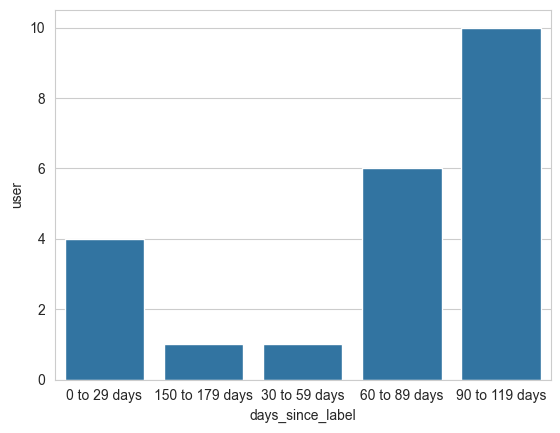

In [46]:


sns.barplot(x='days_since_label', y='user', data=df_date_bands) #hue='variable')
#plt.xticks(rotation=90)
#plt.ylabel('Returns')
#plt.title('Portfolio vs Benchmark Returns');